In [5]:
!nvidia-smi

Fri Nov  3 03:41:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:41:00.0 Off |                  Off |
| 30%   31C    P8              23W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Load LLAMA-2
import torch
import transformers
from datasets import load_dataset

"""
Unused imports:
import torch.nn as nn
import bitsandbytes as bnb
"""


from transformers import LlamaForCausalLM, LlamaTokenizer, LlamaForSequenceClassification, BitsAndBytesConfig


from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    prepare_model_for_kbit_training,
    set_peft_model_state_dict,
    get_peft_config, 
    PromptTuningInit, 
    PromptTuningConfig, 
    TaskType, 
    PeftType,
    PeftModel
)

In [7]:
device_map = {"": 0}

base_model = "meta-llama/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model, use_fast=False)
tokenizer.add_special_tokens(
    {
     
        "pad_token": "<PAD>",
    }
)
special_tokens_dict = {'additional_special_tokens': ['[IMG]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model = LlamaForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map=device_map,
    use_auth_token=True
)
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

/nfshomes/skarki/scratch/miniconda3/envs/llame/lib/python3.9/site-packages/transformers/modeling_utils.py:2478: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/llame/lib/python3.9/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Embedding(32002, 4096)

In [8]:
import torch
import torch.nn as nn
from transformers import Blip2QFormerConfig, Blip2QFormerModel

class QFormer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qformer_config = Blip2QFormerConfig(
            encoder_hidden_size=768
        )
        self.qformer = Blip2QFormerModel(self.qformer_config).to(0)
        self.query_tokens = nn.Parameter(
            torch.zeros(1, 32, 768)
        )
        self.query_tokens.data.normal_(mean=0.0, std=0.02)

    def forward(self, img_embeddings):
        query_tokens = self.query_tokens.expand(img_embeddings.shape[0], -1, -1)
        image_atts = torch.ones(img_embeddings.size()[:-1], dtype=torch.long).to(0)
        qformer_embeddings = self.qformer(
            query_embeds=query_tokens.to(0), 
            encoder_hidden_states=img_embeddings.to(0),
            encoder_attention_mask=image_atts.to(0),
            return_dict=True
        )
        return qformer_embeddings

In [9]:
import torch.nn as nn
qformer = QFormer()

In [10]:
img_token_id = tokenizer("[IMG]", add_special_tokens=False)["input_ids"][0]
img_token_id

32001

In [11]:
import pandas as pd
df = pd.read_json("/nfshomes/skarki/scratch/data/embeddings.json")
df.head()

,image_embeddings,question,answer
0,"[[[0.359248578548431, -0.6500996351242061, -0....",How many other things are there of the same ma...,3
1,"[[[0.11450660973787301, -0.608290016651153, -0...",The green thing that is the same size as the p...,cube
2,"[[[0.13305327296257002, -0.573591530323028, -0...",Is there a large cube that is to the right of ...,yes
3,"[[[0.14678417146205902, -0.359456837177276, -0...",The object that is in front of the cyan cylind...,gray
4,"[[[0.361140221357345, -0.380545675754547, -0.3...",How many rubber blocks have the same color as ...,1


In [12]:
from sklearn.model_selection import train_test_split

random_state = 33
X, X_test = train_test_split(df, test_size=0.2, random_state=33)
X.shape

(1600, 3)

In [13]:
X_test.shape

(400, 3)

In [14]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=33)

In [15]:
X_train.shape, X_val.shape, X_test.shape

((1280, 3), (320, 3), (400, 3))

In [28]:
from torch.utils.data import Dataset, DataLoader

# [IMG] = 32004, [QUESTION] = 32003 [ANSWER] = 32002

system_instruction = "You are a helpful AI assistant that can understand what is going on in an image and respond accordingly."
llama2_prompt = """<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

{user_message} [/INST]"""

class VQADataset(Dataset):
    def __init__(self, df, tokenizer, cutoff_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.cutoff_len = cutoff_len

    def __len__(self):
        return self.df.shape[0]

    def tokenize(self, prompt, add_eos_token=False, padding=True):
        # there's probably a way to do this with the tokenizer settings
        # but again, gotta move fast
        if padding:
            result = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.cutoff_len,
                padding="max_length",
                return_tensors=None,
            )
        else:
            result = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.cutoff_len,
                padding=False,
                return_tensors=None,
            )
        if (
            result["input_ids"][-1] != tokenizer.eos_token_id
            and len(result["input_ids"]) < self.cutoff_len
            and add_eos_token
        ):
            result["input_ids"].append(tokenizer.eos_token_id)
            result["attention_mask"].append(1)

        result["labels"] = result["input_ids"].copy()

        return result
        
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        all_embeddings = torch.tensor(item.image_embeddings)
        cls_embeddings = all_embeddings[:, 0, :]
        prefix = """<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

Given image: [IMG], answer the following question."""
        question = f"QUESTION: {item.question}"
        answer = f"ANSWER: {item.answer} [/INST]"
        
        full_prompt = f"{prefix}\n{question}\n{answer}"
        user_prompt = f"{prefix}\n{question}\n"
        tokenized_full_prompt = self.tokenize(full_prompt)
        img_token_position = tokenized_full_prompt["input_ids"].index(img_token_id)
        
        tokenized_user_prompt = self.tokenize(user_prompt, padding=False)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        # tokenized_full_prompt["labels"] = [
        #         -100
        #     ] * user_prompt_len + tokenized_full_prompt["labels"][
        #         user_prompt_len:
        #     ]  # could be sped up, probably
  
        
        return {
            "cls_embeddings": all_embeddings,
            "input_ids": torch.tensor(tokenized_full_prompt["input_ids"]).reshape(1, -1),
            "attention_mask": torch.tensor(tokenized_full_prompt["attention_mask"]).reshape(1, -1),
            "labels": torch.tensor(tokenized_full_prompt["labels"]).reshape(1, -1),
            "question": item.question,
            "answer": item.answer,
            "img_token_position": img_token_position,
            "user_prompt_len": user_prompt_len
        }



In [29]:
cutoff_len = 120
train_ds = VQADataset(X_train, tokenizer, cutoff_len)
val_ds = VQADataset(X_val, tokenizer, cutoff_len)
test_ds = VQADataset(X_test, tokenizer, cutoff_len)

In [30]:
train_ds[0]["img_token_position"]

29

In [31]:
train_dataloader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=1
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=True,
    num_workers=1
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=True,
    num_workers=1
)

In [32]:
# _x = next(enumerate(train_dataloader))[1]

In [33]:
# img_embeddings = _x["cls_embeddings"].to(0)
# mapped_img_embeddings = vit_to_llm(img_embeddings)    
# ins_embeddings = model.model.embed_tokens(_x["input_ids"]).squeeze(1)
# print(img_embeddings.shape)
# print(mapped_img_embeddings.shape)
# print(ins_embeddings.shape)
# print(batch["img_token_position"])

In [34]:
import torch.nn as nn
vit_to_llm = nn.Linear(768, 4096).to(0)

In [35]:
# for param in vit_to_llm.parameters():
#     # Check if parameter dtype is  Half (float16)
#     print(param.dtype)
#     # if param.dtype == torch.float16:
#     #     param.data = param.data.to(torch.float32)
#     break

In [36]:
# for param in model.model.embed_tokens.parameters():
#     print(param.dtype)
#     break

In [37]:
params_before = [param for param in vit_to_llm.parameters()][:20]
params_before

[Parameter containing:
 tensor([[ 0.0040,  0.0012, -0.0200,  ...,  0.0091,  0.0200, -0.0103],
         [-0.0168,  0.0111,  0.0148,  ..., -0.0203,  0.0206,  0.0323],
         [-0.0209, -0.0118,  0.0174,  ...,  0.0074,  0.0306, -0.0146],
         ...,
         [-0.0224,  0.0089,  0.0295,  ..., -0.0059, -0.0097,  0.0096],
         [-0.0110, -0.0020,  0.0228,  ...,  0.0088, -0.0129,  0.0210],
         [-0.0227,  0.0126, -0.0082,  ..., -0.0141, -0.0335,  0.0048]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0353, -0.0054, -0.0068,  ..., -0.0131,  0.0016,  0.0251],
        device='cuda:0', requires_grad=True)]

In [38]:
# before
qformer_params_before = [param for param in qformer.parameters()][:20]
qformer_params_before

[Parameter containing:
 tensor([[[ 0.0109, -0.0233, -0.0165,  ...,  0.0414, -0.0464, -0.0215],
          [ 0.0080, -0.0041,  0.0140,  ..., -0.0576,  0.0012, -0.0045],
          [-0.0168, -0.0271,  0.0107,  ...,  0.0161, -0.0172,  0.0129],
          ...,
          [ 0.0072,  0.0137,  0.0220,  ..., -0.0033,  0.0084, -0.0202],
          [-0.0084, -0.0199, -0.0028,  ...,  0.0063,  0.0239, -0.0079],
          [ 0.0131,  0.0339,  0.0049,  ..., -0.0108, -0.0389,  0.0320]]],
        requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [39]:
qformer.query_tokens

Parameter containing:
tensor([[[ 0.0109, -0.0233, -0.0165,  ...,  0.0414, -0.0464, -0.0215],
         [ 0.0080, -0.0041,  0.0140,  ..., -0.0576,  0.0012, -0.0045],
         [-0.0168, -0.0271,  0.0107,  ...,  0.0161, -0.0172,  0.0129],
         ...,
         [ 0.0072,  0.0137,  0.0220,  ..., -0.0033,  0.0084, -0.0202],
         [-0.0084, -0.0199, -0.0028,  ...,  0.0063,  0.0239, -0.0079],
         [ 0.0131,  0.0339,  0.0049,  ..., -0.0108, -0.0389,  0.0320]]],
       requires_grad=True)

In [41]:
qformer.query_tokens

Parameter containing:
tensor([[[ 0.0109, -0.0232, -0.0164,  ...,  0.0415, -0.0464, -0.0215],
         [ 0.0080, -0.0042,  0.0140,  ..., -0.0576,  0.0011, -0.0045],
         [-0.0169, -0.0272,  0.0106,  ...,  0.0160, -0.0173,  0.0128],
         ...,
         [ 0.0072,  0.0137,  0.0220,  ..., -0.0033,  0.0084, -0.0201],
         [-0.0084, -0.0199, -0.0026,  ...,  0.0063,  0.0239, -0.0078],
         [ 0.0132,  0.0338,  0.0049,  ..., -0.0108, -0.0390,  0.0319]]],
       requires_grad=True)

In [40]:
from tqdm import tqdm
from torch.optim import AdamW
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import random
from torch.autograd import Variable
from itertools import chain

lr = 1e-5

loss_fn = torch.nn.CrossEntropyLoss()

params = chain(
    qformer.parameters(),
    vit_to_llm.parameters()
)

optimizer = AdamW(params=params, lr=lr)
losses_total = []

grads_total = []

num_epochs = 1

for epoch in tqdm(range(num_epochs)):
  with tqdm(train_dataloader, leave=False) as t:
      t.set_description('Eval loop')
      for i, batch in enumerate(t):
          labels = batch["labels"].squeeze(1)
          img_embeddings = batch["cls_embeddings"].squeeze(1).to(0)

          # image_atts = torch.ones(img_embeddings.size()[:-1], dtype=torch.long).to(0)

          # query_tokens = query_tokens.expand(img_embeddings.shape[0], -1, -1)
    
          # qformer_embeddings = qformer(
          #     query_embeds=query_tokens.to(0), 
          #     encoder_hidden_states=img_embeddings.to(0),
          #     encoder_attention_mask=image_atts.to(0),
          #     return_dict=True
          # )

          qformer_embeddings = qformer.forward(img_embeddings)
          blip_embeds = qformer_embeddings.pooler_output
          mapped_img_embeddings = vit_to_llm(blip_embeds).unsqueeze(1)
          attn_mask = batch["attention_mask"].squeeze(1)
          ins_embeddings = model.model.embed_tokens(batch["input_ids"]).squeeze(1)
          input_embeds = torch.cat([
              ins_embeddings[:, :29, :].to(0), 
              mapped_img_embeddings.to(0), 
              ins_embeddings[:, 30:, :].to(0)], dim=1
          )
          out = model(inputs_embeds=input_embeds.half(), attention_mask=attn_mask, labels=labels)
          loss = out.loss
          t.set_postfix(loss=loss.item())
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
        
          losses_total.append(loss.item())
          # if i % 20 == 0:
          #     print(loss.item())

100%|██████████| 1/1 [02:48<00:00, 168.71s/it]                         


In [45]:
idx = 85
_c = test_ds[idx]

labels = _c["labels"]
img_embeddings = _c["cls_embeddings"].to(0)
user_prompt_len = _c["user_prompt_len"]
print(_c["question"])
print(_c["answer"])
print(img_embeddings.shape)

qformer_embeddings = qformer.forward(img_embeddings)
blip_embeds = qformer_embeddings.pooler_output
mapped_img_embeddings = vit_to_llm(blip_embeds).unsqueeze(1)

attn_mask = _c["attention_mask"]
ins_embeddings = model.model.embed_tokens(_c["input_ids"])

input_embeds = torch.cat([
  ins_embeddings[:, :27, :].to(0), 
  mapped_img_embeddings.to(0), 
  ins_embeddings[:, 28: user_prompt_len, :].to(0)], dim=1
)

_gen = model.generate(
    inputs_embeds=input_embeds.half(),
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=100
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)

What is the size of the blue block?
large
torch.Size([1, 197, 768])
tensor([[    1,  2190, 23066,  1001, 29901, 29871, 29906,   518, 29914, 25580,
         29962, 32000, 32000, 32000, 32000, 32000, 29901,  4587,  3236, 29991,
           450,  2159,   310,   278,  7254,  2908,   338, 29871, 29906, 29889,
           518, 29896, 29914, 29900, 29962,     2]], device='cuda:0')


In [46]:
tokenizer.batch_decode(seq, skip_special_tokens=True)

['ANSWER: 2 [/INST]: Of course! The size of the blue block is 2. [1/0]']

In [156]:
dummy_df = X_test[150:250]
dummy_df = dummy_df.rename(columns={"question": "original_question"})

In [157]:
dummy_df["question"] = dummy_df.apply(lambda x: "Describe what you see in the image.\nANSWER:", axis=1)
dummy_df.head()

,image_embeddings,original_question,answer,question
1434,"[[[0.23486834764480502, -0.49981391429901106, ...",There is a large purple metallic thing that is...,cube,Describe what you see in the image.\nANSWER:
1257,"[[[0.15651199221611, -0.348443746566772, -0.13...",Is there any other thing that is the same mate...,no,Describe what you see in the image.\nANSWER:
1239,"[[[0.277773320674896, -0.429942339658737, -0.2...",What number of green things are either rubber ...,1,Describe what you see in the image.\nANSWER:
586,"[[[0.41794687509536704, -0.41856023669242803, ...",There is a sphere that is made of the same mat...,purple,Describe what you see in the image.\nANSWER:
1956,"[[[0.434557169675827, -0.38867333531379705, -0...",Are there fewer purple cylinders than gray sph...,yes,Describe what you see in the image.\nANSWER:


In [86]:
cutoff_len

120

In [158]:
dummy_ds = VQADataset(dummy_df, tokenizer, 256)

In [88]:
dummy_ds[0]["user_prompt_len"]

55

In [161]:
# idx = 120

for idx in range(71, 81):
    _c = dummy_ds[idx]
    df_item = dummy_df.iloc[idx]
    labels = _c["labels"]
    user_prompt_len = _c["user_prompt_len"]
    img_embeddings = _c["cls_embeddings"].to(0)
    print("Question: ", _c["question"])
    print("Original question (not given to the model):", df_item["original_question"])
    print("Answer: ", _c["answer"])
    
    qformer_embeddings = qformer.forward(img_embeddings)
    blip_embeds = qformer_embeddings.pooler_output
    mapped_img_embeddings = vit_to_llm(blip_embeds).unsqueeze(1)
    
    attn_mask = _c["attention_mask"]
    ins_embeddings = model.model.embed_tokens(_c["input_ids"])
    
    input_embeds = torch.cat([
      ins_embeddings[:, :27, :].to(0), 
      mapped_img_embeddings.to(0), 
      ins_embeddings[:, 28: user_prompt_len, :].to(0)], dim=1
    )
    _gen = model.generate(
        inputs_embeds=input_embeds.half(),
        return_dict_in_generate=True,
        output_scores=True,
        output_hidden_states=True,
        max_new_tokens=250
    )
    hs = _gen.hidden_states
    seq = _gen.sequences
    print(tokenizer.batch_decode(seq, skip_special_tokens=True))
    print("-" * 50)

Question:  Describe what you see in the image.
ANSWER:
Original question (not given to the model): There is another large object that is the same shape as the big cyan metallic thing; what material is it?
Answer:  rubber
["The image shows a small object that is the same color as the background and has a small dot on it. It is located in the top left corner of the image. [/INST]kov'skylavskylavskylavs]lerkylavs] lerky]"]
--------------------------------------------------
Question:  Describe what you see in the image.
ANSWER:
Original question (not given to the model): Are there the same number of tiny spheres that are right of the cyan block and big yellow cubes that are in front of the big yellow matte object?
Answer:  yes
['The small metal object is the same shade of blue as the sphere [/INST] material! (1/4)\n\nThe image depicts a small metal object that appears to be the same shade of blue as the sphere in the background. The metal object is small and cylindrical in shape, with a sm

KeyboardInterrupt: 

In [ ]:
# import torch
# from PIL import Image
# import requests
# from transformers import Blip2Processor, Blip2Model

# device = 0
# blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model_blip = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
# model_blip.to(device)
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = blip_processor(images=image, return_tensors="pt").to(device, torch.float16)
# qformer_outputs = model_blip.get_qformer_features(**inputs)

In [94]:
!ls

dataset			  langauge_table_image_data.pkl  Untitled.ipynb
Experimentation.ipynb	  language_table_tutorial.ipynb  VLM_Encoder.ipynb
Experimentation-v2.ipynb  README.md			 VQA-training.ipynb
__init__.py		  tokenizer			 VQA-trainingv2.ipynb


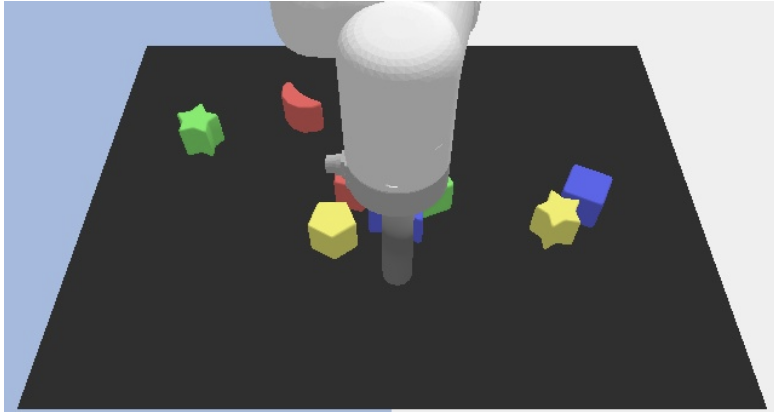

In [171]:
from transformers import AutoImageProcessor, ViTModel
import torch
from PIL import Image


img = Image.open("./test-img.png").convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = image_processor(img, return_tensors="pt")

with torch.no_grad():
    outputs = model_vit(**inputs)

last_hidden_states = outputs.last_hidden_state
img

In [189]:
_data = {'image_embeddings': last_hidden_states.unsqueeze(0).tolist(), 'question': "How many yellow objects are there in the image?", "answer": "hoge"}
_df = pd.DataFrame.from_dict(_data)
_df.head()

,image_embeddings,question,answer
0,"[[[0.3613165318965912, -0.3458535969257355, 0....",How many yellow objects are there in the image?,hoge


In [190]:
_ds = VQADataset(_df, tokenizer, 256)

In [192]:
_c = _ds[0]
labels = _c["labels"]
user_prompt_len = _c["user_prompt_len"]
img_embeddings = _c["cls_embeddings"].to(0)
print("Question: ", _c["question"])
# print("Answer: ", _c["answer"])

qformer_embeddings = qformer.forward(img_embeddings)
blip_embeds = qformer_embeddings.pooler_output
mapped_img_embeddings = vit_to_llm(blip_embeds).unsqueeze(1)

attn_mask = _c["attention_mask"]
ins_embeddings = model.model.embed_tokens(_c["input_ids"])

input_embeds = torch.cat([
  ins_embeddings[:, :27, :].to(0), 
  mapped_img_embeddings.to(0), 
  ins_embeddings[:, 28: user_prompt_len, :].to(0)], dim=1
)
_gen = model.generate(
    inputs_embeds=input_embeds.half(),
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=250
)
hs = _gen.hidden_states
seq = _gen.sequences
print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])
print("-" * 50)

Question:  How many yellow objects are there in the image?
ANSWER: [2] (1 rubber ball and 1 yellow cube)
[/INST]  Sure, I can help you with that! Here is the answer to the question you provided:

There are 2 yellow objects in the image:

1. The yellow rubber ball (1)
2. The yellow cube (1)

So, the answer is [2] (1 rubber ball and 1 yellow cube).
--------------------------------------------------


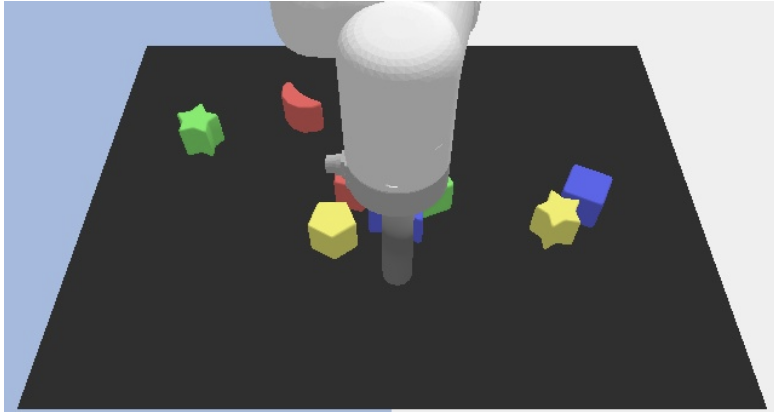

In [193]:
img